# NMR Echo Train processing and creation of an NMR log in Real-Time:

This Jupyter Notebook uses the existing MRIL T2 bin porosities to create an NMR log echo train with random noise that is then used to test one of our 3 SciPy metods for T2 inversion. 

The T2 inversion methods developed in this notebook were developed with collaboration with chatGPT. We wanted to experiment with this AI tool to see if we could create the code to perform NMR log T2 inversion. We are using SciPy least_squares, optimization and curve_fit libraries in Python with Tikhonov regularization, which incorporates a penalty term based on the sum of the squared parameters. Although the initial code provided by ChatGPT required some fine-tuning, it was a great starting point.

Our [repository on GitHub](https://github.com/Philliec459/NMR-Log-Echo-Train-Inversion-in-Geolog-using-Scipy-Optimization) also includes a complete Geolog project with Geolog python loglans to perform the same process as used in this notebook.

The process starts with creating an echo train with random noise from the existing bin porosities from a MRIL C tool job using the multi-exponential decay rate defined by the function below:

    def func(x,p1,p2,p3,p4,p5,p6,p7,p8):
    return (p1*np.exp(-x/4)+p2*np.exp(-x/8)+p3*np.exp(-x/16)+p4*np.exp(-x/32)+p5*np.exp(-x/64)+p6*np.exp(-x/128)+p7*np.exp(-x/256)+p8*np.exp(-x/512))


The time axis, xdata, is in msec for 200 echoes with a TE of 1.2 msec:

    # create x array with 200 elements
    num_echoes = 200
    TE = 1.2  # echo spacing (ms)
    x = np.arange(num_echoes) * TE
    xdata = x

We add random noise to this echo train using the code below: 

    y_noise  = noise * np.random.normal(size=xdata.size)
    ydata = y + y_noise

We then apply our T2 inversion using this synthetic echo train with noise employing one of the 3 methods from SciPy shown below: 

    '''
    -----------------------------------------------------------------------------------------------
      T2 Inversion using SciPy with regularization or SciPy curve_fit options:
    -----------------------------------------------------------------------------------------------
    '''
 
    if method == 'least_squares' : 
        # Set the value of alpha
        alpha = 0.1
        # Set the initial parameter values
        p0 = np.ones(8)
        # Set the bounds
        bounds = ([0]*8, [20]*8)
        # Fit the data to the function with L2 regularization using scipy.optimize
        result = least_squares(objective, p0, args=(xdata, ystack, alpha), bounds=bounds)
        popt = result.x    
    elif method == 'Optimize':
        lambda_ = 0.1  #started with 0.1
        p0 = np.ones(8)
        result = minimize(obj_func, p0, args=(xdata, ystack, lambda_), method='L-BFGS-B', bounds=[(0, 20)]*8)
        popt = result.x
    elif method == 'Curve_fit_simple' : 
        popt, pcov = curve_fit(func, xdata, ystack, method='trf', bounds=(0.05, [20, 20, 20, 20, 20, 20, 20, 20])) 
        
![NMR_log](NMR_log.gif)


### Channel X and Y Data
In an attempt to make this more realistic, we created our own Channel X and Channel Y data from the original echo train (ydata) using our pre-defined phase rotation values in radians to calculate the X and Y data. We then again use phase rotation correction to create a phase corrected echo train for the T2 inversion similar to what we might do with the channel echo train data on a typical MRIL run well using the following code:

### Calculate a pseudo X and Y channle data bassed on the phase_angle_radian and the origial echo train ydata

#### [We are using phase angles in radians](https://en.wikipedia.org/wiki/Radian).
    
![Geolog](radians.gif)  


Rotate the initial echo train to create X and Y component data:

    Channel_X = ydata * np.cos(phase_angle_rad) # Echo train real
    Channel_Y = ydata * np.sin(phase_angle_rad)  # Quadrature channel

and then re-apply the phase rotation to create a new echo train for the T2 inversion:

    echo_train_real = np.real(Channel_X) / np.cos(phase_angle_rad)
    echo_train_imag = np.imag(Channel_Y) / np.sin(phase_angle_rad)


![T2_inversion_phase](T2_inversion_phase.gif)

Prior to T2 inversion, we typically stack the echo_train_real for better signal to noise, and then apply one of the 3 SciPy inversion techniques as shown above. 

We also have all of this code as [Geolog python loglans with a complete Geolog project included in our GitHub repository](https://github.com/Philliec459/NMR-Log-Echo-Train-Inversion-in-Geolog-using-Scipy-Optimization).

![Geolog_Image](Geolog_loglan.png)

In this project there is a Geolog layout to view the new T2 inversion results along with the original NMR log data to compare the results.

![Geolog_Image](results.png)

Please let us know if there are any issues.

## Import Python libraries:

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  8 12:33:54 2020

@author: craig
"""
%matplotlib inline
#%matplotlib tk

#from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Read in NMR log and T2 bin data used to create the echo train in this instance:

In [2]:
#df = pd.read_csv('nmr.csv',index_col=0)
df = pd.read_csv('nmr.csv')

print(df.head())

    Depth   MPHI      P1      P2      P3      P4      P5     P6      P7  \
0  7177.0  3.294  0.7960  0.6230  0.1180  0.0130  0.0160  0.172  0.5560   
1  7177.5  3.002  0.3010  0.3500  0.2220  0.1540  0.2040  0.392  0.6140   
2  7178.0  3.289  0.0620  0.2170  0.3430  0.3800  0.4260  0.528  0.6300   
3  7178.5  4.568  0.0480  0.3030  0.6280  0.7910  0.7770  0.715  0.6670   
4  7179.0  5.397  0.1835  0.3435  0.6465  0.9735  1.0485  0.902  0.7175   

       P8   MFFI    MBVI  
0  0.9980  1.756  1.5370  
1  0.7650  2.129  0.8730  
2  0.7020  2.668  0.6220  
3  0.6390  3.590  0.9790  
4  0.5825  4.224  1.1735  


## Define the level spacing, number of levels to stack and random noise to introduce into the echo trains:

In [3]:
'''
    ---------------------------------------------------------------------------
    This is where we want to stack the data for a less noisy echotrain
    
    Set Level Spacing, Stacking levels and Noise below
      
            *** Stack_levels from 1 (no stacking) to 9 stacked levels *** 
    ---------------------------------------------------------------------------
'''
level_spacing = .5  # well level spacing and this model works best on 0.5 data???
stack_levels  = 3   # odd numbers are geat, even changes level spacing in new depth offset of 0.25 ' 
noise_level   = 1.5 # in porosity units
'''
--------------------------------------------------------------------------------
             *** Stack_levels from 1 (no stacking) to 9 stacked levels *** 
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------

                         *** Set T2 Inversion parameters ***

--------------------------------------------------------------------------------

Do you want to use SciPy Optimization or SciPy least_squares methods, both with regularization?

SciPy curve_fit does not have regularization so far.
'''
method = []

method = 'least_squares'
#method = 'Optimize'
#method = 'Curve_fit_simple'

'''
Set the value of alpha for least_squares regularization, or lambda_ for optimization regularization
'''
alpha   = 0.12  # least squares regularization
lambda_ = 0.12  # Optimization regularization


## [We are using phase angles in radians](https://en.wikipedia.org/wiki/Radian)
    
![Geolog](radians.gif)  

### Choose the phase angle that you want to use:

    phase_angle = np.pi/2 sets the variable phase_angle to the value of pi/2, 
    which is approximately 1.5707963267948966 radians or 90 degrees.

    phase_angle = np.pi/4 sets the variable phase_angle to the value of pi/4, 
    which is approximately 0.7853981633974483 radians or 45 degrees.

    phase_angle = np.pi/6 sets the variable phase_angle to the value of pi/6, 
    which is approximately 0.5235987755982988 radians or 30 degrees.

    phase_angle = np.pi/8 sets the variable phase_angle to the value of pi/8, 
    which is approximately 0.39269908169872414 radians or 22.5 degrees.



In [4]:
'''Enter the phase anlge in radians'''
# Choose a phase angle
phase_angle_rad = np.pi/8
print('phase_angle_rad =',round(phase_angle_rad, 2))
phase_angle_deg = np.rad2deg(phase_angle_rad)
print('phase_angle_deg =',round(phase_angle_deg, 2))
print()


phase_angle_rad = 0.39
phase_angle_deg = 22.5



# Create Echo Trains and then use SciPy least_squares or Optimization with regularization for the T2 inversion:

For SciPy least_squares Alpha=0 has no optimization

The parameter **lambda_** in SciPy Optimization determines the strength of the regularization with this method. 
You can adjust the value of lambda_ to find a good balance between fitting the data and preventing overfitting.


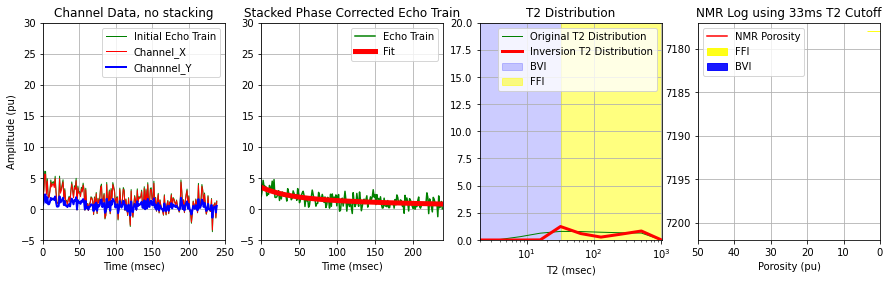

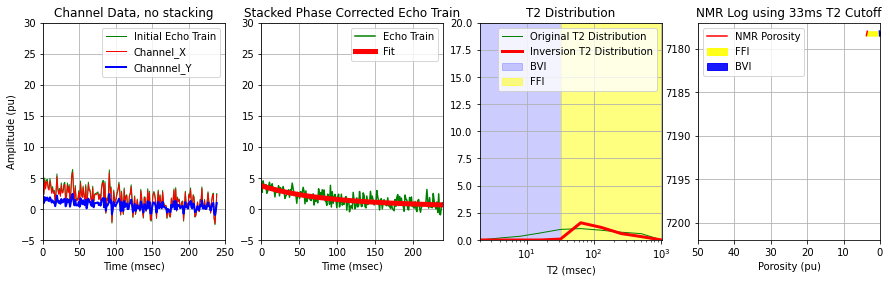

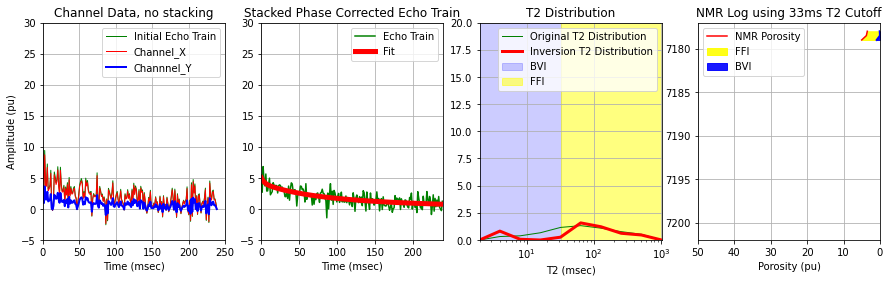

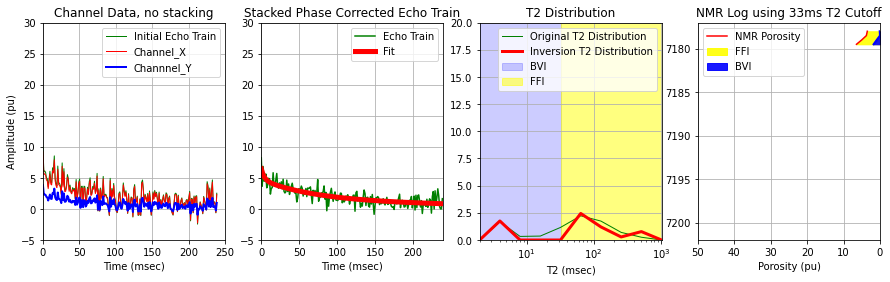

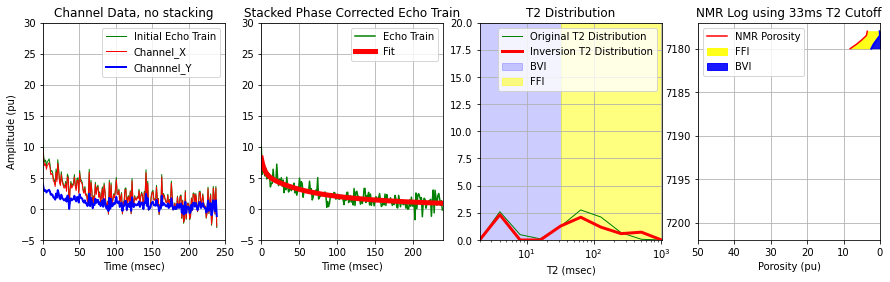

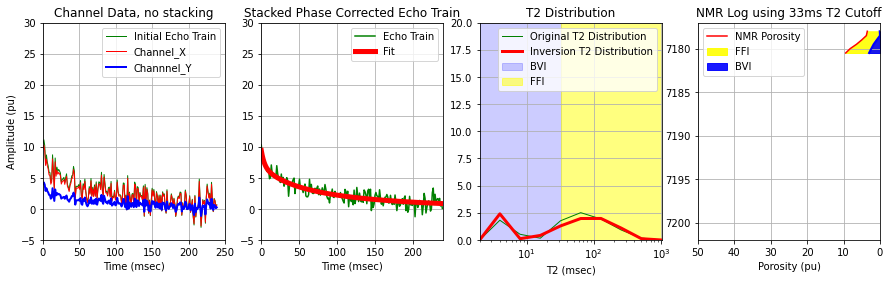

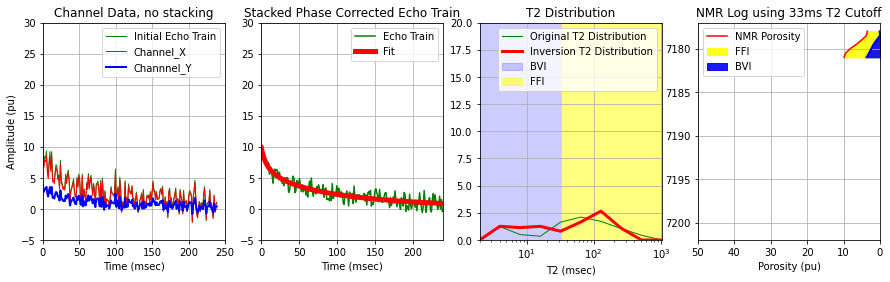

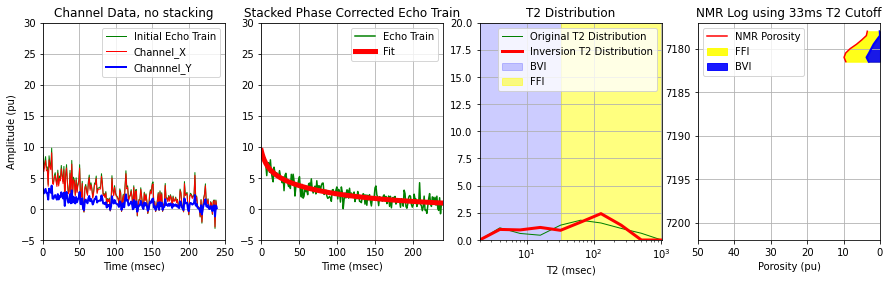

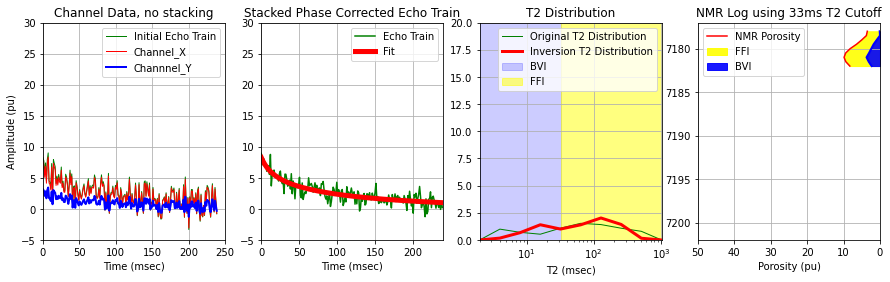

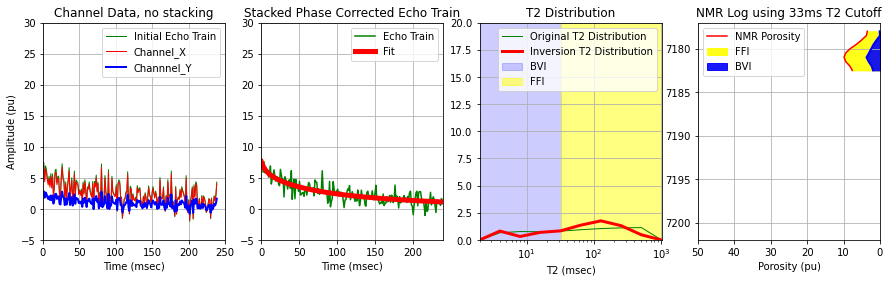

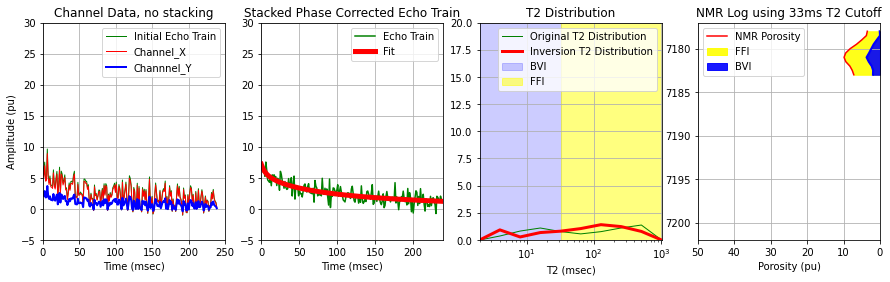

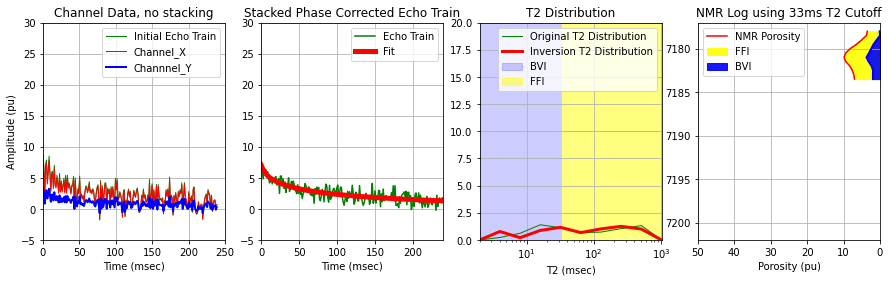

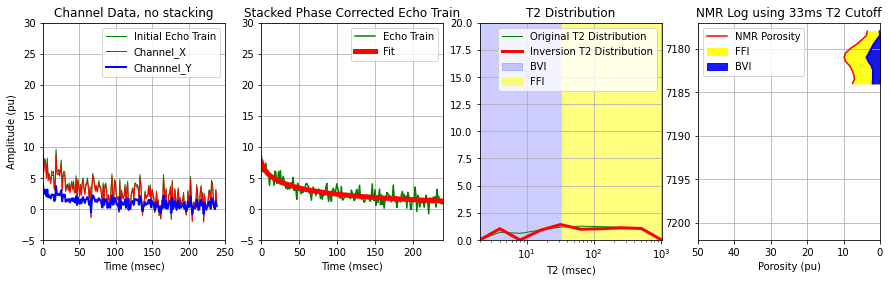

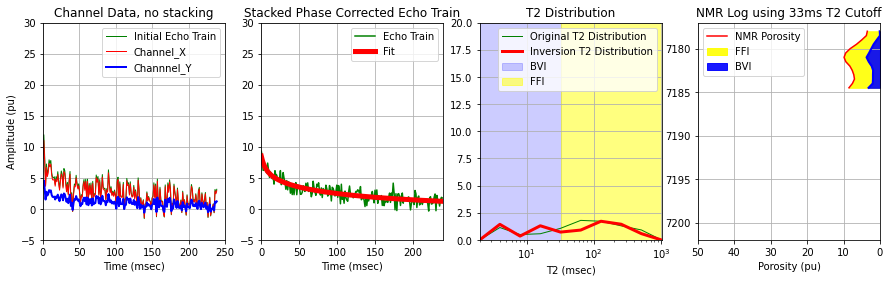

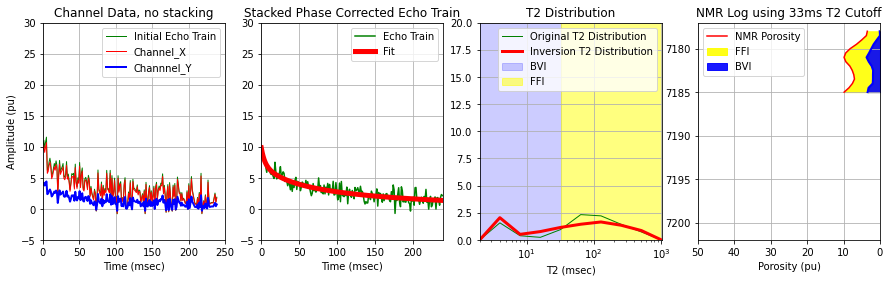

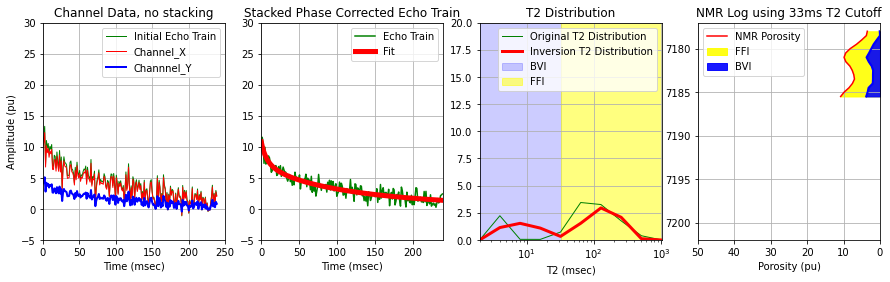

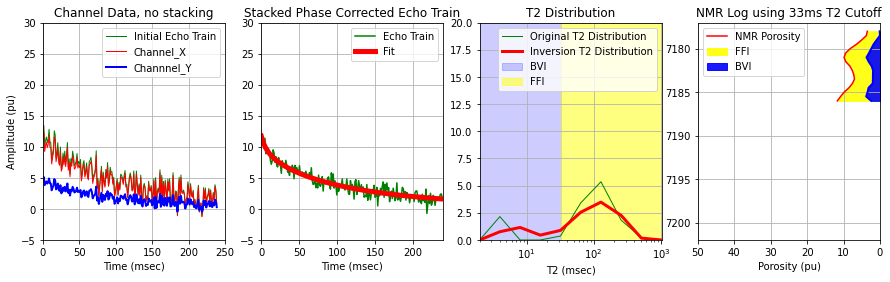

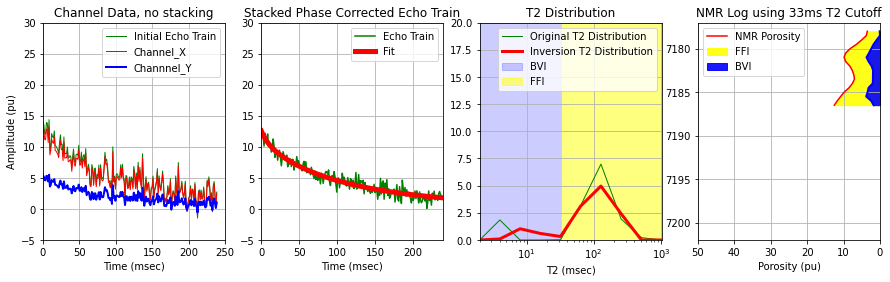

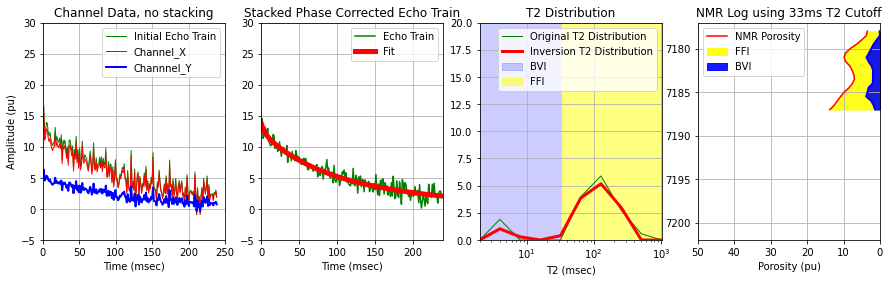

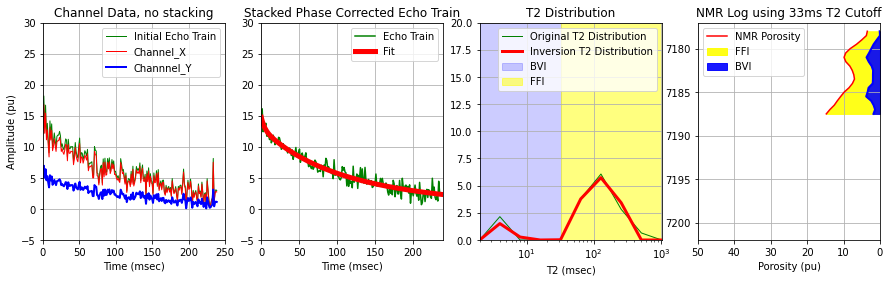

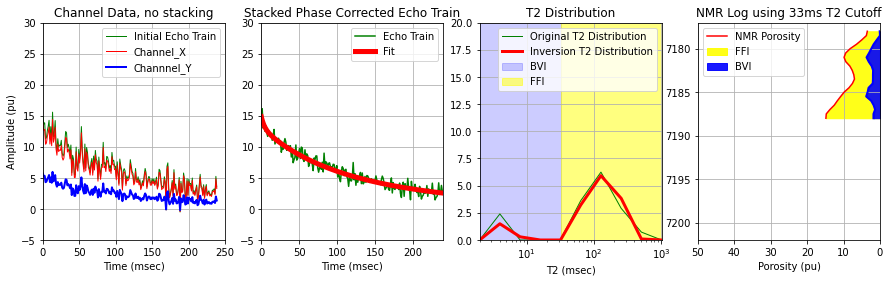

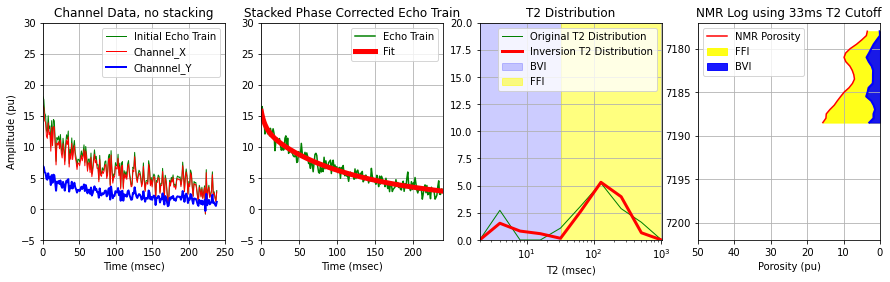

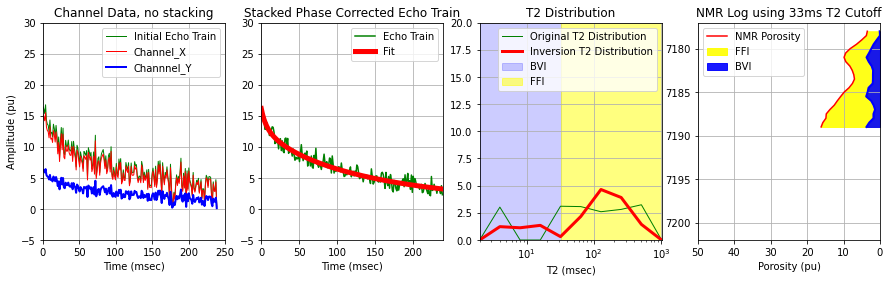

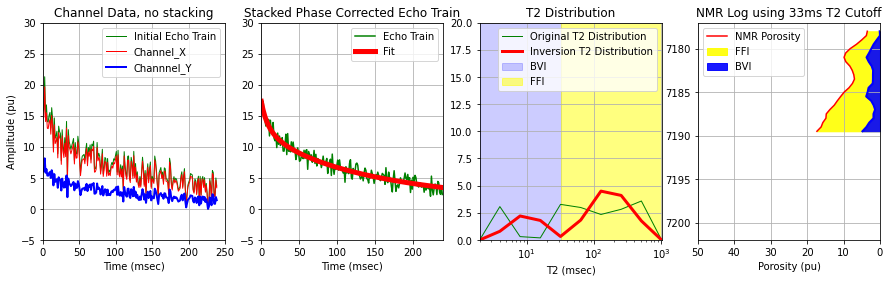

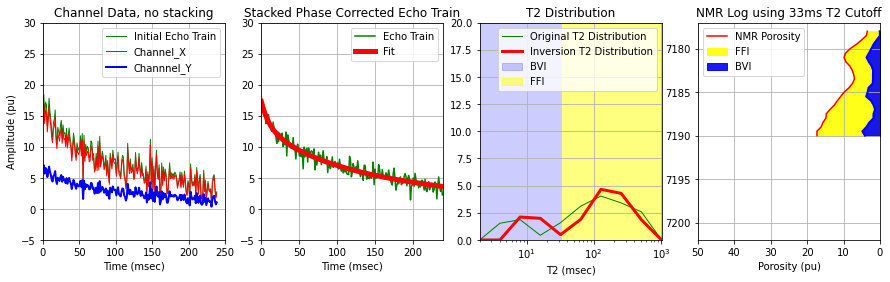

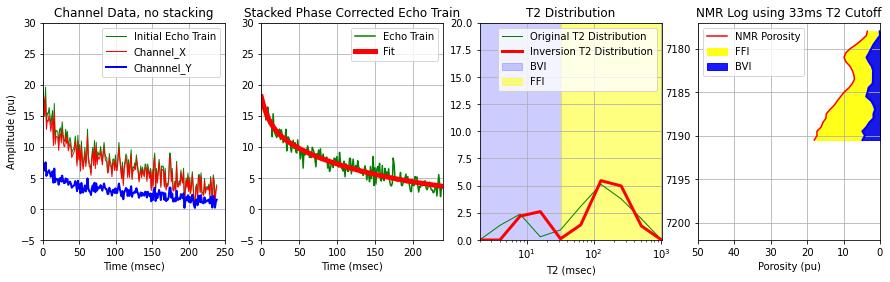

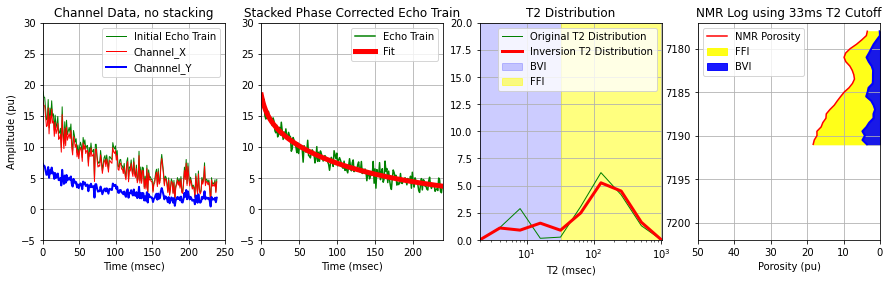

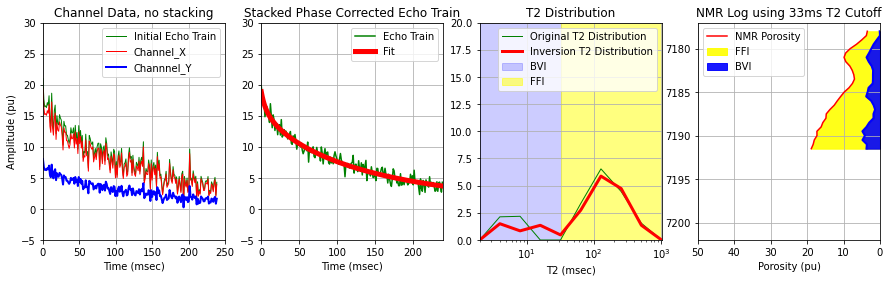

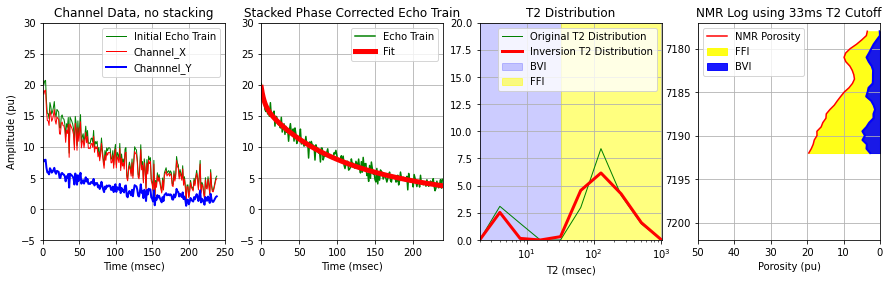

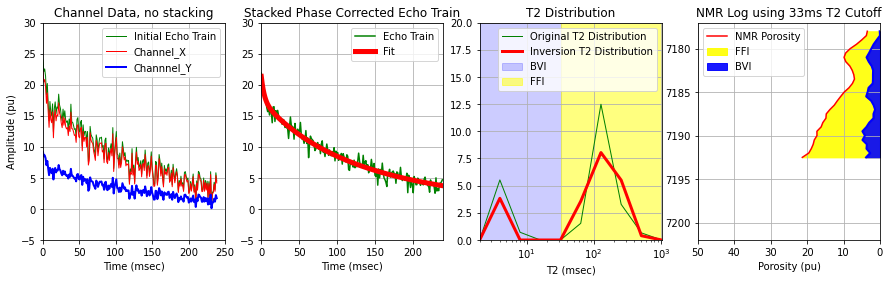

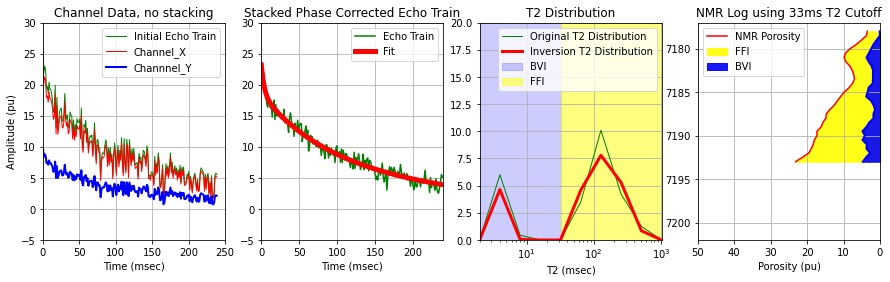

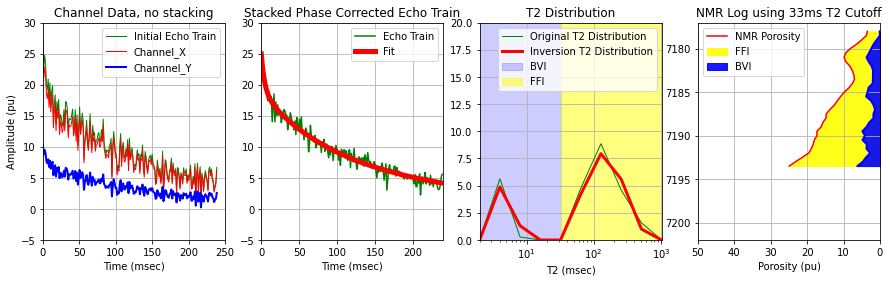

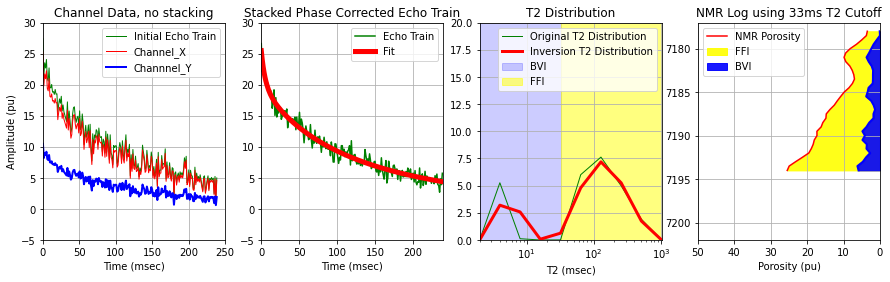

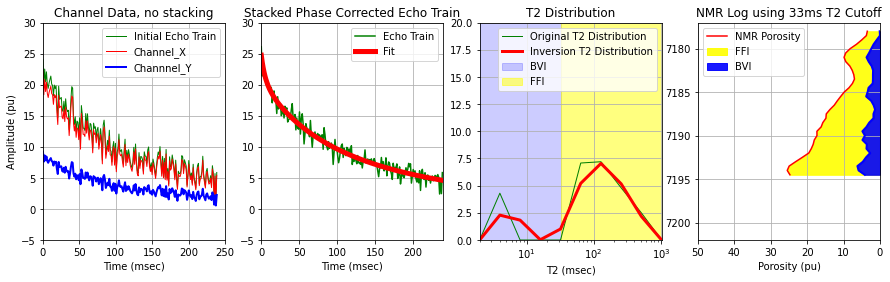

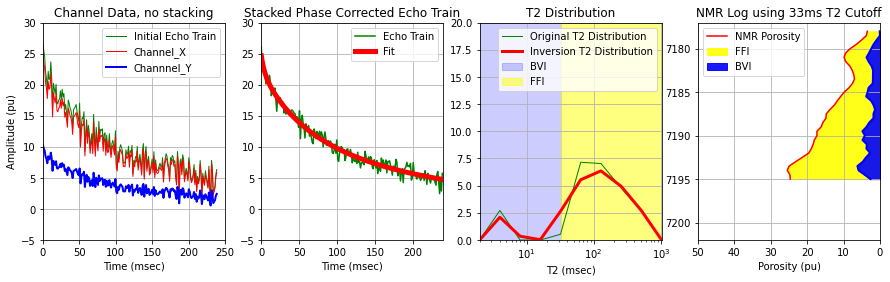

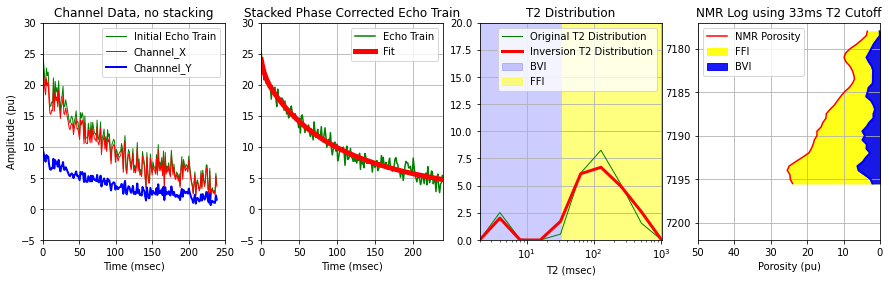

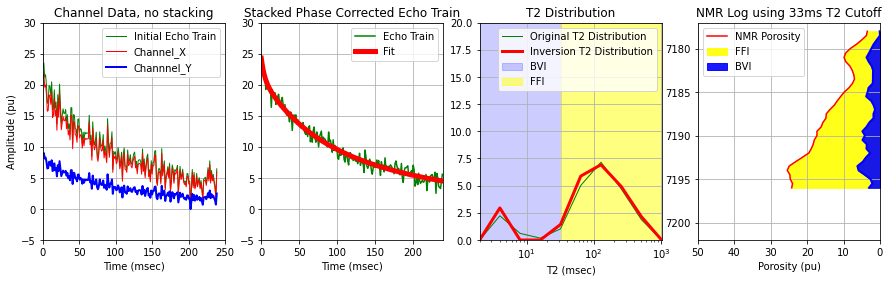

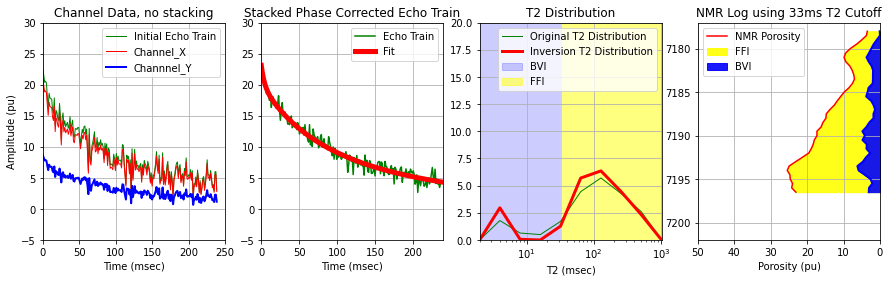

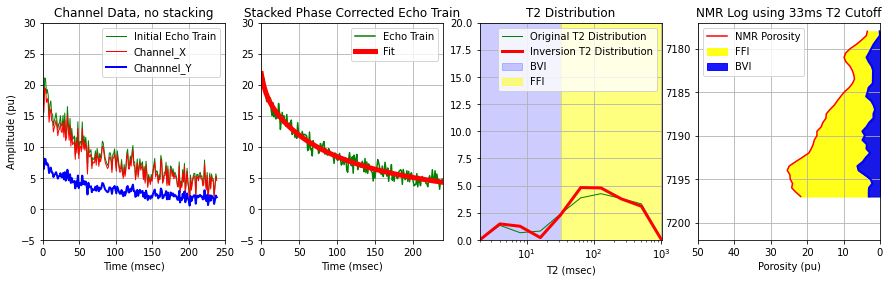

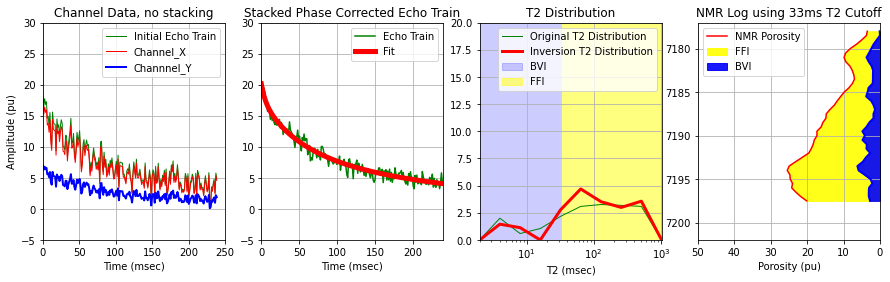

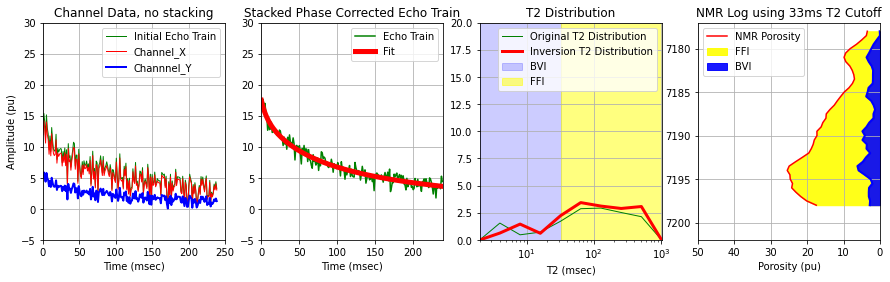

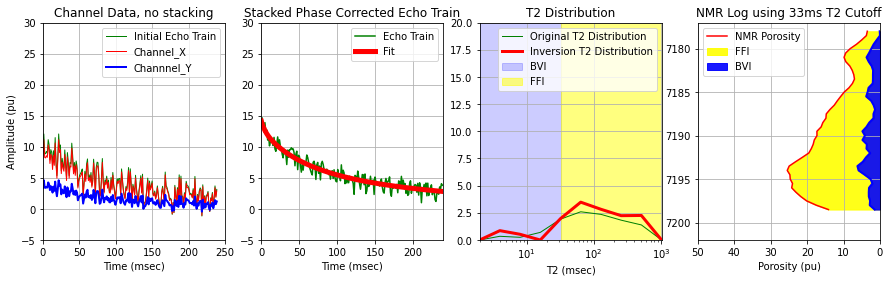

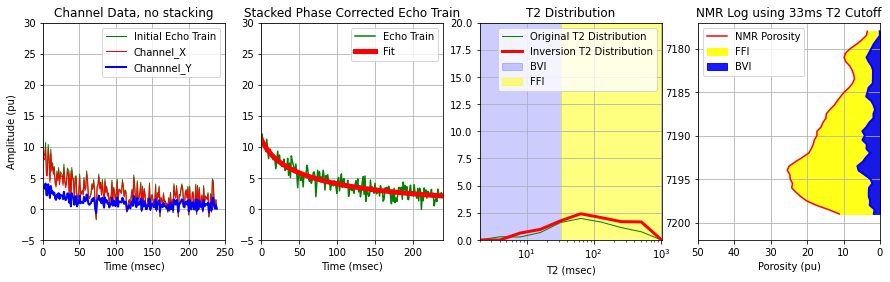

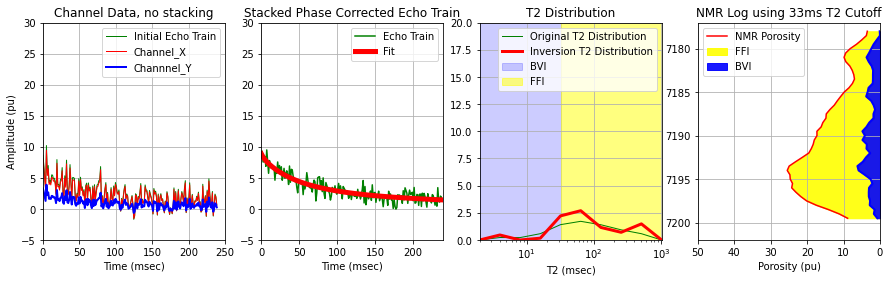

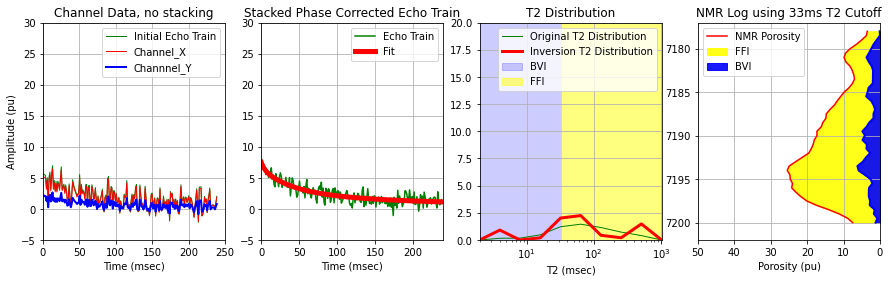

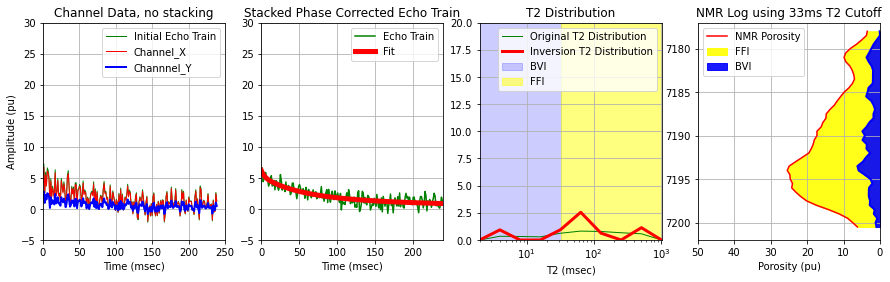

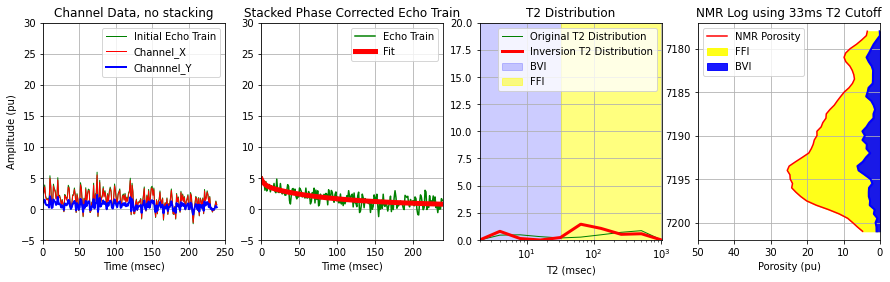

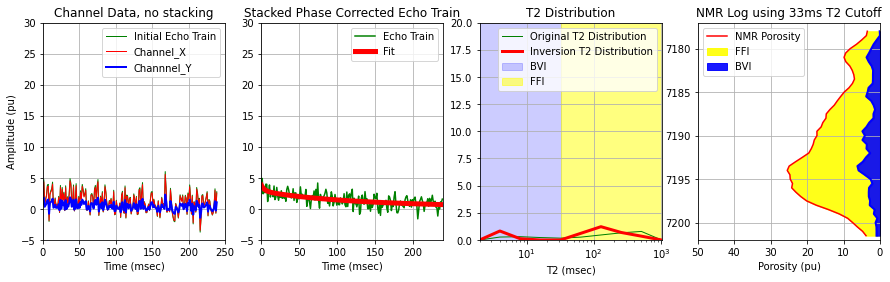

In [5]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

T2 =[2,4,8,16,32,64,128,256,512,1024,2048]

def func(x,p1,p2,p3,p4,p5,p6,p7,p8):
    return (p1*np.exp(-x/4)+p2*np.exp(-x/8)+p3*np.exp(-x/16)+p4*np.exp(-x/32)+p5*np.exp(-x/64)+p6*np.exp(-x/128)+p7*np.exp(-x/256)+p8*np.exp(-x/512))


def obj_func(params, x, y, lambda_):
    p1, p2, p3, p4, p5, p6, p7, p8 = params
    residuals = y - func(x, p1, p2, p3, p4, p5, p6, p7, p8)
    regularization = lambda_ * (p1**2 + p2**2 + p3**2 + p4**2 + p5**2 + p6**2 + p7**2 + p8**2)
    return np.sum(residuals**2) + regularization

# Define the objective function to be minimized, including a regularization term
def objective(p, x, y, alpha):
    y_pred = func(x, *p)
    error = y - y_pred
    regularization_term = alpha * np.sum(np.square(p))
    return np.concatenate([error, np.sqrt(alpha) * p])


deptharray=[]
mphiarray=[]    
mbviarray=[]
mffiarray=[]    
echo=[]
ystack=[]
T21=[]
T22 = []
#ystack2=[]
#ystackecho=[]

for index, row in df.iterrows():
    P0=0
    P1=row['P1']
    P2=row['P2']
    P3=row['P3']
    P4=row['P4']
    P5=row['P5']
    P6=row['P6']
    P7=row['P7']
    P8=row['P8']
    P9=0
    P10=0
    mphi=row['MPHI']
    mbvi=row['MBVI']
    depth=row['Depth']
    bins=[P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10]

    p1 = P1
    p2 = P2
    p3 = P3
    p4 = P4
    p5 = P5
    p6 = P6
    p7 = P7
    p8 = P8 
    
    # Define the T2 times
    T2_times = np.array([4, 8, 16, 32, 64, 128, 256, 512])

    # create x array with 200 elements
    num_echoes = 200
    TE = 1.2  # echo spacing (ms)
    x = np.arange(num_echoes) * TE
    xdata = x

    
    '''
      Calculate Echo Train data using xdata and func for echo train equation
    '''
    y = func(xdata,P1, P2, P3,  P4, P5, P6,  P7,  P8)

    '''
      add noise to the echo train data to create a typical echo train
    '''
    y_noise  = noise_level * np.random.normal(size=xdata.size)
    ydata = y + y_noise
    
    
    ''' Calculate a pseudo X and Y channle data bassed on the phase_angle_radian and the origial echo train ydata'''
    # Rotate the noise echo train to create real and imaginary components
    Channel_X = ydata * np.cos(phase_angle_rad) # Echo train real
    #print('np.cos(phase_angle_rad) =',round(np.cos(phase_angle_rad),2))
    Channel_Y = ydata * np.sin(phase_angle_rad)  # Quadrature channel
    


    
    # Combine real and imaginary channels to create final echo train
    echo_train_real = np.real(Channel_X) / np.cos(phase_angle_rad)    
    
    # Apply phase rotation to quadrature channel
    #y_imaginary = y_with_noise_quadrature * np.exp(-1j * phase_angle)
    echo_train_imag = np.imag(Channel_Y) / np.sin(phase_angle_rad)
    #echo_train_imag = Channel_Y * np.exp(-1j * (phase_angle_rad))

    ydata = echo_train_real

    
    '''
      Store Echo Trains in np array
    '''
    echo.append(ydata)
    yecho = pd.DataFrame(echo)
                 
    ''' This is stacking of echo trains for better S/N'''
    if index > stack_levels -1:
        if stack_levels == 1:           
            ystack=ydata
        else:
            for k in range(1,stack_levels): 
    
                if stack_levels == 2:
                    ystack = (echo[index-1]+echo[index])/stack_levels                 
                elif stack_levels == 3:
                    ystack = (echo[index-2]+echo[index-1]+echo[index])/stack_levels
                elif stack_levels ==4:
                    ystack = (echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels
                elif stack_levels == 5:
                    ystack = (echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels
                elif stack_levels == 6:
                    ystack = (echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                elif stack_levels == 7:
                    ystack = (echo[index-6]+echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                elif stack_levels == 8:
                    ystack = (echo[index-7]+echo[index-6]+echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                elif stack_levels == 9:
                    ystack = (echo[index-8]+echo[index-7]+echo[index-6]+echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                    
                else:
                    print('Stack Levels out of bounds')
     
        '''
        -----------------------------------------------------------------------------------------------
          T2 inversion using SciPy with regularization or SciPy curve_fit options:
        -----------------------------------------------------------------------------------------------
        '''
        # Fit the function to the data with regularization
        #bnds = [(0, 20)]*8
        
        if method == 'least_squares' : 
            # Set the value of alpha
            #alpha = 0.1
            # Set the initial parameter values
            p0 = np.ones(8)
            # Set the bounds
            bounds = ([0]*8, [20]*8)
            # Fit the data to the function with L2 regularization using scipy.optimize
            result = least_squares(objective, p0, args=(xdata, ystack, alpha), bounds=bounds)
            popt = result.x    
        elif method == 'Optimize':
            #lambda_ = 0.1  #started with 0.1
            p0 = np.ones(8)
            result = minimize(obj_func, p0, args=(xdata, ystack, lambda_), method='L-BFGS-B', bounds=[(0, 20)]*8)
            popt = result.x
        elif method == 'Curve_fit_simple' : 
            #lambda_ = alpha
            #p0 = np.ones(8)
            #popt, pcov = curve_fit(obj_func, p0, y_data, args=(xdata, lambda_))
            popt, pcov = curve_fit(func, xdata, ystack, method='trf', bounds=(0.05, [20, 20, 20, 20, 20, 20, 20, 20]))        
            #popt, pcov = curve_fit(obj_func, p0, xdata, ystack, lambda_ ,bounds= (0.05, [20, 20, 20, 20, 20, 20, 20, 20]))        
        
        #print("Inversion Porosities:" , popt)
        
        
        ''' Calculate BVI, MFFI and MPHI '''
        mbviarray.append(popt[0]+popt[1]+popt[2]+0.044*popt[3])    
        mphiarray.append(popt[0]+popt[1]+popt[2]+popt[3]+popt[4]+popt[5]+popt[6]+popt[7])
        mffiarray.append((1-0.044)*popt[3]+popt[4]+popt[5]+popt[6]+popt[7])

        multiplier = (1 - level_spacing)/2
        deptharray.append(depth - (stack_levels-1)/2 + multiplier*(stack_levels-1))
        
        optbins  = [P0,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],P9,  P10] 
        T2       = [2,  4,      8,     16,     32,     64,     128,    256,   512,   1024, 2048]
        #bins    = [P0, P1,    P2,     P3,     P4,     P5,      P6,     P7,    P8,    P9,   P10]


        
        
        
        
        
        
        #-------------------------------------------------------------------------------------------------
        #-------------------------------------------------------------------------------------------------
        #------     Plot Echo Train and create NMR log T2 Dist, MPHI and MBVI from T2 Inversion      -----
        #-------------------------------------------------------------------------------------------------
        #-------------------------------------------------------------------------------------------------
        for p in range(1):
            p=0
            
            fig, ax = plt.subplots(1,4,figsize=(15,4))      
            updated_x = xdata
            updated_y = ystack
            updated_yfit = func(xdata, *popt)
            
            
            ax[0].plot(updated_x,ydata      ,c='green',linewidth=1  , label='Initial Echo Train')
            ax[0].plot(updated_x,Channel_X ,c='red'  ,linewidth=1  , label='Channel_X') 
            ax[0].plot(updated_x,Channel_Y ,c='blue' ,linewidth=2  , label='Channnel_Y') 
            ax[0].set_xlim(0,250)
            ax[0].set_ylim(-5,30)
            ax[0].set_ylabel('Amplitude (pu)')
            ax[0].set_xlabel('Time (msec)')
            ax[0].set_title('Channel Data, no stacking')
            ax[0].legend(loc='upper right')
            ax[0].grid()
           
            
            ax[1].plot(updated_x,updated_y    ,c='green',label='Echo Train')
            ax[1].plot(updated_x,updated_yfit ,c='red',linewidth=5, label='Fit') 
            ax[1].set_xlim(0,240)
            ax[1].set_ylim(-5,30)
            #ax[1].set_ylabel('Amplitude (pu)')
            ax[1].set_xlabel('Time (msec)')
            ax[1].set_title('Stacked Phase Corrected Echo Train')
            ax[1].legend(loc='upper right')
            ax[1].grid()
            
            #ax.figure(2)
            ax[2].semilogx(T2,bins, c='green', linewidth=1, label = 'Original T2 Distribution')
            ax[2].semilogx(T2,optbins,c='red', linewidth=3, label = 'Inversion T2 Distribution')        
            #ax[1].semilogx(33,0.0 ,'b*')
            ax[2].set_xlim(2,1024)
            ax[2].set_ylim(0,20)
            #ax[2].set_ylabel('Bin Porosity (pu)')
            ax[2].set_xlabel('T2 (msec)')
            ax[2].set_title('T2 Distribution')
            ax[2].axvspan(2,33,alpha=0.2,color='blue',label='BVI')
            ax[2].axvspan(33,1024,alpha=0.5,color='yellow',label='FFI')
            ax[2].legend()
            ax[2].grid()
            
            ax[3].plot(mphiarray,deptharray ,c='red',label='NMR Porosity')
            ax[3].plot(mbviarray,deptharray ,c='blue',linewidth=2)
            ax[3].set_xlim(50,0)
            ax[3].set_ylim(max(df['Depth']),min(df['Depth']))
            #ax[3].set_ylim(12.5,0)
            #ax[3].set_ylabel('Depth)')
            ax[3].set_xlabel('Porosity (pu)')
            ax[3].set_title('NMR Log using 33ms T2 Cutoff') 
            ax[3].fill_betweenx(deptharray, mphiarray, 0,  color='yellow', alpha=0.9, label='FFI')   
            ax[3].fill_betweenx(deptharray, mbviarray, 0,  color='blue'  , alpha=0.9, label='BVI')    
            ax[3].legend(loc='upper left')
            ax[3].grid()
              
            plt.draw()  
            updated_x = xdata
            updated_y = ystack
            updated_yfit = func(xdata, *popt)
            plt.pause(0.05)
            #fig.clear()
            plt.close(fig)
            #fig.clf()
                 



## Calculated Phase Angle in degrees and radians from the Channel data similar to what you might do if you had Channel X and Channel Y from a typical MRIL job:

In [6]:
#find line of best fit
a, b = np.polyfit(Channel_X, Channel_Y, 1)
#plt.plot(Channel_X, a*Channel_X + b,color='black', linestyle='--', linewidth=3)        
#plt.text(1, 17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + ' * x')

print('phase_angle used =', round(np.rad2deg(phase_angle_rad),1),', phase_angle_rad used =',round(phase_angle_rad,2))
print('phase_angle calc at end =', round(np.rad2deg(np.arctan(a)),1),', phase_angle_rad calc at end =',round(np.arctan(a),2))


phase_angle used = 22.5 , phase_angle_rad used = 0.39
phase_angle calc at end = 22.5 , phase_angle_rad calc at end = 0.39


# Write out new NMR T2 inversion results with Echo Train to Excel file:

In [7]:
file_out = pd.merge(df, yecho ,left_index=True,right_index=True)

file_out.to_excel('nmr_echos.xlsx', index = False)